In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: install tim

!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
test_dataset = AccidentDataset(data_dir + 'test', transform=transform)

# Use 20% of the dataset for training
train_size = int(0.6 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders with Reduced Batch Size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the Attention Module
class Attention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Attention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(out_channels, 1, kernel_size=1)

    def forward(self, x):
        query = self.conv1(x)
        key = self.conv2(x)
        value = x

        attention = torch.sigmoid(self.conv3(torch.relu(query + key)))
        out = value * attention
        return out

# Define the CNN with Attention Model
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Update the Attention module to match the CNN output channels
        self.attention = Attention(256, 256)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.attention(x)
        x = self.classifier(x)
        return x

# Initialize the Model
model = CNNWithAttention()
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training, Validation, and Testing
num_epochs = 10
history_cnn_attention = {
    'train_losses': [],
    'val_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'test_accuracies': [],
}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    history_cnn_attention['train_losses'].append(running_loss / len(train_loader))
    history_cnn_attention['train_accuracies'].append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    history_cnn_attention['val_losses'].append(val_running_loss / len(val_loader))
    history_cnn_attention['val_accuracies'].append(val_correct / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {history_cnn_attention["train_losses"][-1]:.4f}, Val Loss: {history_cnn_attention["val_losses"][-1]:.4f}, Train Acc: {history_cnn_attention["train_accuracies"][-1]:.4f}, Val Acc: {history_cnn_attention["val_accuracies"][-1]:.4f}')

# Save the model and history
model_path = f'/content/drive/MyDrive/cnn_attention_finetuned.pth'
torch.save(model.state_dict(), model_path)

history_path = f'/content/drive/MyDrive/cnn_attention_history.pth'
torch.save(history_cnn_attention, history_path)


Epoch 1/10, Train Loss: 2.9892, Val Loss: 0.6782, Train Acc: 0.5401, Val Acc: 0.5102
Epoch 2/10, Train Loss: 0.6827, Val Loss: 0.6777, Train Acc: 0.5907, Val Acc: 0.5816
Epoch 3/10, Train Loss: 0.6624, Val Loss: 0.6255, Train Acc: 0.6287, Val Acc: 0.6327
Epoch 4/10, Train Loss: 0.6118, Val Loss: 0.6061, Train Acc: 0.6857, Val Acc: 0.7449
Epoch 5/10, Train Loss: 0.5685, Val Loss: 0.5983, Train Acc: 0.7257, Val Acc: 0.7551
Epoch 6/10, Train Loss: 0.5209, Val Loss: 0.5049, Train Acc: 0.7658, Val Acc: 0.7551
Epoch 7/10, Train Loss: 0.4603, Val Loss: 0.5431, Train Acc: 0.8017, Val Acc: 0.7347
Epoch 8/10, Train Loss: 0.4317, Val Loss: 0.3475, Train Acc: 0.8080, Val Acc: 0.8367
Epoch 9/10, Train Loss: 0.3615, Val Loss: 0.5079, Train Acc: 0.8460, Val Acc: 0.7551
Epoch 10/10, Train Loss: 0.3680, Val Loss: 0.4473, Train Acc: 0.8629, Val Acc: 0.7857


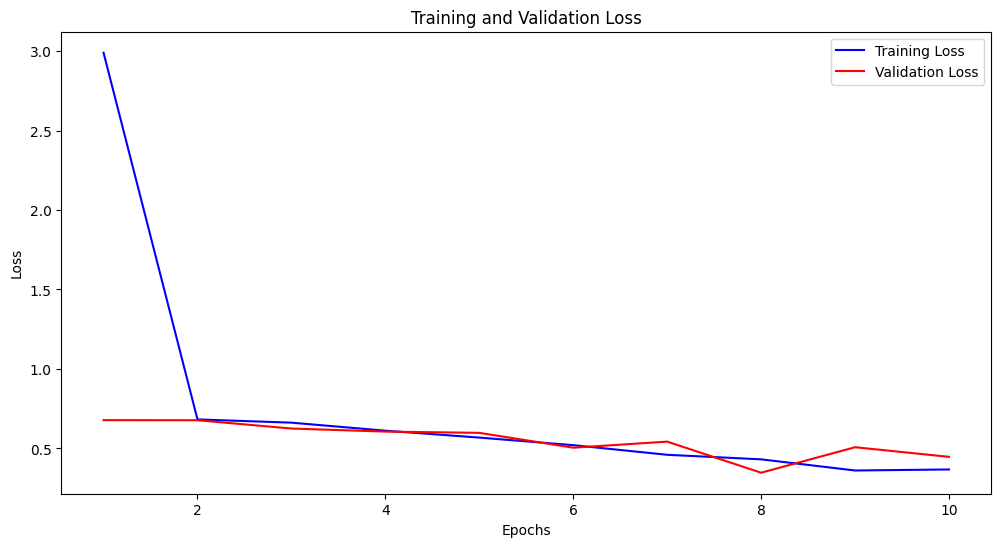

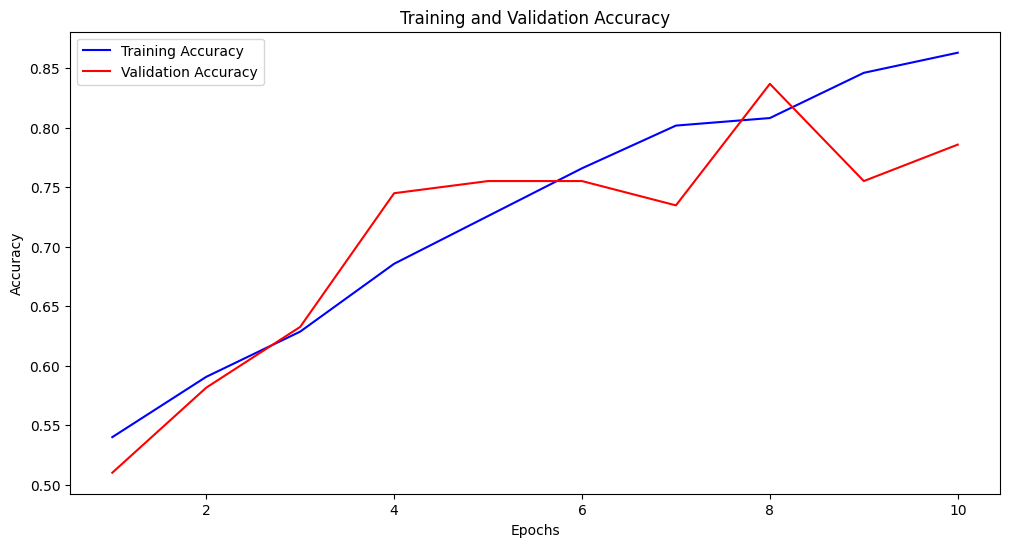

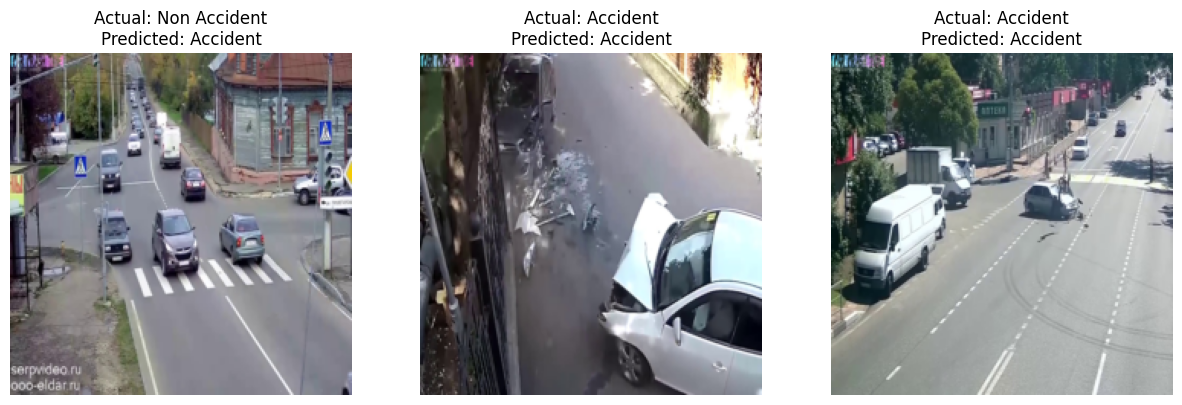

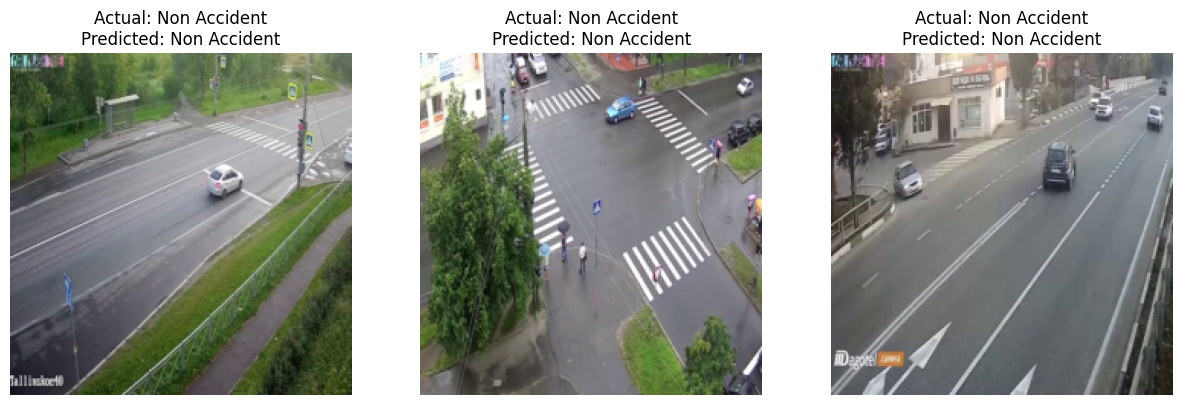

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77        52
           1       0.72      0.89      0.80        46

    accuracy                           0.79        98
   macro avg       0.80      0.79      0.79        98
weighted avg       0.80      0.79      0.78        98

Confusion Matrix:
[[36 16]
 [ 5 41]]


In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Load the history for plotting
history_cnn_attention = torch.load('/content/drive/MyDrive/cnn_attention_history.pth')

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_cnn_attention)

# Load the trained model
model_cnn_attention = CNNWithAttention()
model_cnn_attention.load_state_dict(torch.load('/content/drive/MyDrive/cnn_attention_finetuned.pth'))
model_cnn_attention = model_cnn_attention.to(device)
model_cnn_attention.eval()

# Visualize Predictions on the Validation Set
def visualize_predictions(model, val_loader, num_images=3):
    model.eval()
    accident_images = []
    non_accident_images = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                # Collect accident images
                if preds[i] == 1 and len(accident_images) < num_images:
                    accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                # Collect non-accident images
                elif preds[i] == 0 and len(non_accident_images) < num_images:
                    non_accident_images.append((inputs[i].cpu(), labels[i], preds[i]))

                # Stop if we have enough images
                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break
            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: {"Accident" if actual == 1 else "Non Accident"}\nPredicted: {"Accident" if predicted == 1 else "Non Accident"}')
        plt.axis('off')
    plt.show()

    # Plot Non Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: {"Accident" if actual == 1 else "Non Accident"}\nPredicted: {"Accident" if predicted == 1 else "Non Accident"}')
        plt.axis('off')
    plt.show()

visualize_predictions(model_cnn_attention, val_loader, num_images=3)

# Classification Report and Confusion Matrix
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_cnn_attention(inputs).squeeze()
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
